<a href="https://colab.research.google.com/github/jaydigy/jayg_colab_gate/blob/main/ak_makemore_pt5_by_jayg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [155]:
!wget "https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt"

--2023-05-25 03:22:03--  https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.4’

names.txt.4         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-05-25 03:22:03 (8.05 MB/s) - ‘names.txt.4’ saved [228145/228145]



In [156]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

     

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [157]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [158]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [159]:
#build the dataset
block_size = 8 #context length : how many chracters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%
     

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [160]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [161]:
# near copy paste of the layers we have developed in Part 3
#------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])
#-----------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
#-----------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
    # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [162]:
torch.manual_seed(42)

In [165]:
n_embd = 24 # the dimensionality of the chracter embedding vectors
n_hidden = 128 # the number of the neurons in the hidden layer of MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),     
    # Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])
# parameter init
with torch.no_grad():
    #last layer make less confident
    # layers[-1].gamma *= 0.1
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
# parameters = [ p for layer in layers for p in layer.parameters()]
# parameters = [C] + [ p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters :
    p.requires_grad = True


76579


In [168]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [170]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 10, 15, 19,  9,  5, 12],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0, 18,  9,  4,  4,  8,  9, 13],
        [ 0,  0,  0,  0,  0,  2, 18, 25]])

In [171]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # Forward Pass
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # x =Xb
    # for layer in layers : 
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters :
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

    # with torch.no_grad():
    #     ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    #if i >= 1000:
    #    break # adter debug : wold take out obviously to run full optimization

      0 /  200000 : 3.2419
  10000 /  200000 : 2.0300
  20000 /  200000 : 2.0328
  30000 /  200000 : 2.2841
  40000 /  200000 : 2.4687
  50000 /  200000 : 2.2215
  60000 /  200000 : 1.6124
  70000 /  200000 : 1.6834
  80000 /  200000 : 1.6670
  90000 /  200000 : 1.8828
 100000 /  200000 : 2.2550
 110000 /  200000 : 1.7745
 120000 /  200000 : 1.8963
 130000 /  200000 : 1.8466
 140000 /  200000 : 1.7527
 150000 /  200000 : 1.9305
 160000 /  200000 : 1.7586
 170000 /  200000 : 1.6499
 180000 /  200000 : 2.0147
 190000 /  200000 : 1.7293


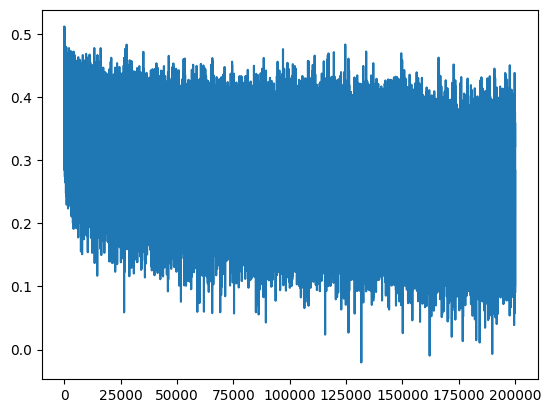

In [172]:
plt.plot(lossi)

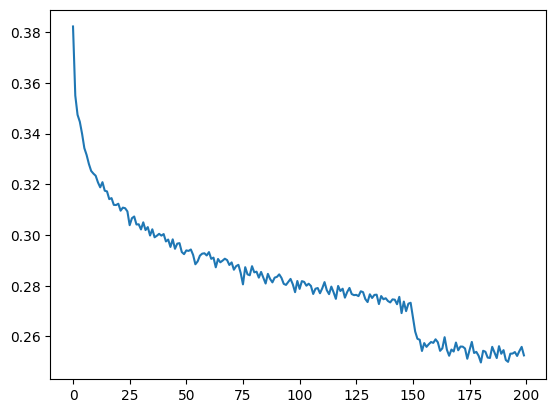

In [173]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [174]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [175]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
#   emb = C[x] # (N, block_size, n_embd)
#   x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#   for layer in layers:
#     x = layer(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# # put layers into eval mode
# for layer in layers:
#   layer.training = False
split_loss('train')
split_loss('val')

train 1.7652804851531982
val 1.9878184795379639


original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
context: 3 -> 8 (22K params): train 1.918, val 2.027
flat -> hierarchical (22K params): train 1.941, val 2.029
fix bug in batchnorm: train 1.912, val 2.022
scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993 굵은 텍스트

In [177]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
    #   emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    #   x = emb.view(emb.shape[0], -1) # concatenate the vectors
    #   for layer in layers:
    #     x = layer(x)
    #   logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

morday.
yazliee.
madylynn.
rethan.
endra.
grazeen.
meliah.
miloe.
leighana.
anarielle.
malkea.
nosalyn.
giagrace.
kendree.
jerenten.
fiustineda.
jamyla.
eliyana.
mystou.
mahil.
